In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import sys
#sys.path.append('../utils')
sys.path.append('../')
from utils.geometry import calc_distance 

from dataloaders.dataloader import DataLoader 
from utils.find_compatible_hits_dev import Find_Compatible_Hits_ModuleMap_Line_New
import keras
from sklearn.model_selection import train_test_split
import multiprocessing as mp
from functools import partial
import time


from keras.models import Sequential
from keras.layers import Dense 
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from tensorflow.keras import regularizers

2023-01-09 20:24:08.601502: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/lhv14/.mujoco/mujoco210/bin
2023-01-09 20:24:08.601527: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
!pwd

/home/lhv14/GCRL/DDPG/notebooks


In [2]:
dl = DataLoader() 
hits, allowed_pids = dl.load_data_trackml(0)

../dataloaders/dataloader.py:157: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  self.hits[['next_mod_id', 'connecting_layer_id']] = self.hits.groupby('particle_id')['discrete_module_id', 'unique_layer_id'].shift(-1)


In [3]:
hits

,hit_id,x,y,z,r,layer_id,volume_id,module_id,phi,particle_id,pt,nhits,q,discrete_module_id,Unnamed: 0,unique_layer_id,z_2,diff_z
0,40897,3.011360,-0.224460,81.750000,3.019714,6,9,52,-0.074400,382808236069224448,0.677168,12,1,3515,30,20.0,82.250000,0.500000
1,8965,0.571231,-2.968350,-69.750000,3.022814,12,7,31,-1.380680,328768064197754880,0.457434,13,-1,570,26,12.0,-70.199997,-0.449997
2,10267,-1.268410,2.744500,-69.800003,3.023432,12,7,90,2.003720,207169431149740032,0.272782,10,-1,629,26,12.0,-70.250000,-0.449997
3,35879,0.065512,-3.023100,59.799999,3.023810,2,9,25,-1.549129,405342245844156416,0.168487,13,1,3272,28,18.0,60.200001,0.400002
4,38021,-1.251360,-2.754950,70.199997,3.025831,4,9,17,-1.997156,792636420635230208,0.224269,12,1,3372,29,19.0,81.750000,11.550003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76528,87227,-102.432999,-4.452600,-107.860001,102.529724,4,17,1,-3.098152,481912991516721152,0.362321,16,1,14948,15,10.0,NaN,NaN
76529,88557,33.507103,-96.901901,-36.340000,102.531479,4,17,958,-1.237883,481887359151898624,0.561965,13,-1,15905,15,10.0,NaN,NaN
76530,90916,55.879997,85.968399,62.340004,102.533607,4,17,2532,0.994417,274721089098088448,0.701133,11,1,17479,15,10.0,NaN,NaN
76531,89133,12.445000,101.776001,-16.820000,102.534058,4,17,1327,1.449122,333296608995180544,0.862122,15,1,16274,15,10.0,NaN,NaN


In [5]:
p = hits[hits['particle_id']==5.899836458134405e+17]

In [6]:
p

,particle_id,unique_layer_id,hit_id,x,y,z,r,layer_id,volume_id,module_id,phi,pt,nhits,q,discrete_module_id,Unnamed: 0,z_2,diff_z
42525,589983645813440512,18.0,36213,3.863370,-4.296470,59.750000,5.753104,2,9,39,-0.835033,8.63127,13,1,3286,28,70.199997,10.449997
42526,589983645813440512,19.0,38494,4.544160,-5.024120,70.199997,6.774302,4,9,39,-0.835518,8.63127,13,1,3394,29,82.199997,12.000000
42527,589983645813440512,20.0,40650,5.330620,-5.891060,82.199997,7.944816,6,9,39,-0.835299,8.63127,13,1,3502,30,96.199997,14.000000
42528,589983645813440512,21.0,42665,6.241150,-6.910960,96.199997,9.311998,8,9,39,-0.836282,8.63127,13,1,3610,31,109.800003,13.600006
42529,589983645813440512,22.0,44408,7.127920,-7.923940,109.800003,10.636744,10,9,40,-0.836423,8.63127,13,1,3719,34,129.800003,20.000000
42530,589983645813440512,23.0,45889,8.432540,-9.379610,129.800003,12.589580,12,9,40,-0.837110,8.63127,13,1,3827,33,149.800003,20.000000
42531,589983645813440512,24.0,47100,9.731780,-10.830300,149.800003,14.540026,14,9,40,-0.837517,8.63127,13,1,3935,32,254.550003,104.750000
42532,589983645813440512,35.0,79035,16.547199,-18.463200,254.550003,24.793137,10,14,62,-0.840070,8.63127,13,1,11561,48,294.549988,39.999985
42533,589983645813440512,36.0,79935,19.095200,-21.338001,294.549988,28.634541,12,14,62,-0.840811,8.63127,13,1,11731,47,NaN,NaN


In [49]:
p.groupby('unique_layer_id').min().reset_index()

,unique_layer_id,hit_id,x,y,z,r,layer_id,volume_id,module_id,phi,particle_id,pt,nhits,q,discrete_module_id,Unnamed: 0,z_2,diff_z
0,1.0,13593,-1.918880,2.501520,-25.964899,3.152730,2,8,62,2.225143,328762841517522944,2.475917,12,-1,817,0,-59.799999,-33.835098
1,11.0,12647,-4.499730,5.765210,-60.200001,7.294038,14,7,90,2.230130,328762841517522944,2.475917,12,-1,737,25,-70.199997,-9.999996
2,12.0,10362,-5.261020,6.764220,-70.199997,8.569305,12,7,93,2.231836,328762841517522944,2.475917,12,-1,632,26,-82.199997,-12.000000
3,13.0,7993,-6.181480,7.911240,-82.199997,10.039841,10,7,93,2.234064,328762841517522944,2.475917,12,-1,524,27,-95.800003,-13.600006
4,14.0,5777,-7.254570,9.208310,-96.199997,11.705062,8,7,92,2.235930,328762841517522944,2.475917,12,-1,415,24,-110.199997,-14.000000
5,15.0,3939,-8.334640,10.580999,-110.199997,13.469365,6,7,94,2.237991,328762841517522944,2.475917,12,-1,309,23,-130.199997,-20.000000
6,16.0,2329,-9.887870,12.474900,-130.199997,15.918325,4,7,94,2.241022,328762841517522944,2.475917,12,-1,201,22,-214.850006,-84.650009
7,28.0,50701,-16.504601,20.378799,-214.850006,26.223984,6,12,147,2.251539,328762841517522944,2.475917,12,-1,4490,37,-254.850006,-40.000000
8,29.0,49672,-19.691601,24.127201,-254.850006,31.142910,4,12,147,2.255312,328762841517522944,2.475917,12,-1,4320,36,-294.850006,-40.000000
9,30.0,48621,-22.807600,27.778500,-294.850006,35.942059,2,12,147,2.258243,328762841517522944,2.475917,12,-1,4150,35,NaN,NaN


In [50]:
len(hits)

76533

In [5]:
t = hits.groupby(['particle_id', 'unique_layer_id']).min().reset_index()

In [6]:
t[t['particle_id']==3.2876284151752294e+17]

,particle_id,unique_layer_id,hit_id,x,y,z,r,layer_id,volume_id,module_id,phi,pt,nhits,q,discrete_module_id,Unnamed: 0,z_2,diff_z
18930,328762841517522944,1.0,13593,-1.918880,2.501520,-25.964899,3.152730,2,8,62,2.225143,2.475917,12,-1,817,0,-59.799999,-33.835098
18931,328762841517522944,11.0,12647,-4.499730,5.765210,-60.200001,7.294038,14,7,90,2.230130,2.475917,12,-1,737,25,-70.199997,-9.999996
18932,328762841517522944,12.0,10362,-5.261020,6.764220,-70.199997,8.569305,12,7,93,2.231836,2.475917,12,-1,632,26,-82.199997,-12.000000
18933,328762841517522944,13.0,7993,-6.181480,7.911240,-82.199997,10.039841,10,7,93,2.234064,2.475917,12,-1,524,27,-95.800003,-13.600006
18934,328762841517522944,14.0,5777,-7.254570,9.208310,-96.199997,11.705062,8,7,92,2.235930,2.475917,12,-1,415,24,-110.199997,-14.000000
18935,328762841517522944,15.0,3939,-8.334640,10.580999,-110.199997,13.469365,6,7,94,2.237991,2.475917,12,-1,309,23,-130.199997,-20.000000
18936,328762841517522944,16.0,2329,-9.887870,12.474900,-130.199997,15.918325,4,7,94,2.241022,2.475917,12,-1,201,22,-214.850006,-84.650009
18937,328762841517522944,28.0,50701,-16.504601,20.378799,-214.850006,26.223984,6,12,147,2.251539,2.475917,12,-1,4490,37,-254.850006,-40.000000
18938,328762841517522944,29.0,49672,-19.691601,24.127201,-254.850006,31.142910,4,12,147,2.255312,2.475917,12,-1,4320,36,-294.850006,-40.000000
18939,328762841517522944,30.0,48621,-22.807600,27.778500,-294.850006,35.942059,2,12,147,2.258243,2.475917,12,-1,4150,35,NaN,NaN


In [3]:
allowed_tracks = hits[hits['particle_id'].isin(allowed_pids)]

In [4]:

smallest_rs = allowed_tracks.groupby(['particle_id', 'unique_layer_id'])['r'].min()
allowed_tracks= allowed_tracks.merge(smallest_rs)


allowed_tracks[['prev_z', 'prev_r']] = allowed_tracks.groupby('particle_id')[['z', 'r']].shift(1)
allowed_tracks['m'] = (allowed_tracks['r'] - allowed_tracks['prev_r'])/(allowed_tracks['z'] - allowed_tracks['prev_z'])
allowed_tracks['b'] = allowed_tracks['r'] - allowed_tracks['m']*allowed_tracks['z']
allowed_tracks[['next_r', 'next_z', 'next_hit_id']] = allowed_tracks.groupby('particle_id')[['r', 'z', 'hit_id']].shift(-1)
allowed_tracks = allowed_tracks.dropna()

In [17]:
pid = allowed_pids[0]

In [5]:
comp = Find_Compatible_Hits_ModuleMap_Line_New(allowed_tracks)

In [19]:
df_frame

,Unnamed: 0,index,hit_id,x,y,z,r,layer_id,volume_id,module_id,...,prev_hit_id,prev_z,prev_r,prev_pid,correct_z,correct_r,m,b,is_correct,reward
0,0,35065.0,28452,-5.17963,-10.430500,-11.2495,11.645767,6,8,270,...,23105.0,-6.776280,7.198029,4.503668e+15,-11.249500,11.645767,-0.994164,0.461293,1,3.469073e-07
1,1,34581.0,28444,-5.04274,-10.470301,-11.2397,11.621378,6,8,270,...,23105.0,-6.776280,7.198029,4.503668e+15,-11.249500,11.645767,-0.994164,0.461293,0,2.628458e-02
2,2,35884.0,28445,-5.42090,-10.360399,-11.3227,11.692905,6,8,270,...,23105.0,-6.776280,7.198029,4.503668e+15,-11.249500,11.645767,-0.994164,0.461293,0,8.706418e-02
3,3,31747.0,28436,-5.32020,-10.191000,-11.1406,11.496130,6,8,269,...,23105.0,-6.776280,7.198029,4.503668e+15,-11.249500,11.645767,-0.994164,0.461293,0,1.850691e-01
4,4,32294.0,28440,-4.39836,-10.657599,-11.0541,11.529528,6,8,270,...,23105.0,-6.776280,7.198029,4.503668e+15,-11.249500,11.645767,-0.994164,0.461293,0,2.273606e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420797,5,59258.0,88887,-24.10630,-21.225300,254.8500,32.118950,10,14,21,...,87710.0,214.850006,27.906595,8.691956e+17,254.850006,32.991375,0.128329,0.335207,0,8.724250e-01
420798,6,59250.0,88853,-27.61140,-16.375599,254.8500,32.102177,10,14,15,...,87710.0,214.850006,27.906595,8.691956e+17,254.850006,32.991375,0.128329,0.335207,0,8.891980e-01
420799,7,59068.0,88827,-28.81290,-12.733600,254.5500,31.501232,10,14,12,...,87710.0,214.850006,27.906595,8.691956e+17,254.850006,32.991375,0.128329,0.335207,0,1.520043e+00
420800,8,60127.0,89056,13.68600,-31.988200,254.8500,34.792976,10,14,52,...,87710.0,214.850006,27.906595,8.691956e+17,254.850006,32.991375,0.128329,0.335207,0,1.801601e+00


In [38]:

ans = pd.DataFrame({})
num_close = 10
non = [] 
dl = DataLoader() 


for i in range(1): #tqdm(range(1)): 
    hits, allowed_pids = dl.load_data_trackml(i)
    allowed_tracks = hits[hits['particle_id'].isin(allowed_pids)]
    
    comp = Find_Compatible_Hits_ModuleMap_Line_New(allowed_tracks)


    smallest_rs = allowed_tracks.groupby(['particle_id', 'unique_layer_id'])['r'].min()
    allowed_tracks= allowed_tracks.merge(smallest_rs)


    allowed_tracks[['prev_z', 'prev_r', 'prev_layer_id']] = allowed_tracks.groupby('particle_id')[['z', 'r', 'unique_layer_id']].shift(1)
    #allowed_tracks[['prev_prev_z', 'prev_prev_r']] = allowed_tracks.groupby('particle_id')[['prev_z', 'prev_r']].shift(1)

    allowed_tracks['m'] = (allowed_tracks['r'] - allowed_tracks['prev_r'])/(allowed_tracks['z'] - allowed_tracks['prev_z'])
    allowed_tracks['b'] = allowed_tracks['r'] - allowed_tracks['m']*allowed_tracks['z']
    allowed_tracks[['next_r', 'next_z', 'next_hit_id', 'next_layer_id']] = allowed_tracks.groupby('particle_id')[['r', 'z', 'hit_id', 'unique_layer_id']].shift(-1)
    allowed_tracks = allowed_tracks.dropna()

    for pid in tqdm(np.unique(allowed_tracks.particle_id)): 
        p = allowed_tracks[allowed_tracks['particle_id']==pid]
        for i in range(len(p)): 
            row = p.iloc[i]
            comp_hits = comp.get_comp_hits_notrow(row.z, row.r, row.m, row.b, num_close)[0]
            comp_hits[['prev_hit_id', 'prev_layer_id', 'prev_z', 'prev_r', 'prev_pid', 'prev_prev_z', 'prev_prev_r','correct_z','correct_r', 'm', 'b']] = row[['hit_id', 'unique_layer_id', 'z', 'r', 'particle_id', 'prev_z', 'prev_r', 'next_z', 'next_r', 'm', 'b']]
            comp_hits['is_correct'] = list(map(int, (comp_hits['correct_z'] == comp_hits['z']) & (comp_hits['correct_r'] == comp_hits['r']).values))
            #if sum(comp_hits['is_correct'])==0: 
            #    non.append([pid, index])
            ans = pd.concat([ans, comp_hits], axis=0)
    

../dataloaders/dataloader.py:154: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  self.hits[['next_mod_id', 'connecting_layer_id']] = self.hits.groupby('particle_id')['discrete_module_id', 'unique_layer_id'].shift(-1)
  5%|██████▎                                                                                                             | 299/5445 [00:38<13:54,  6.17it/s]

mwhahha I went here loliz


 42%|████████████████████████████████████████████████▊                                                                  | 2313/5445 [05:29<08:34,  6.09it/s]

mwhahha I went here loliz


 59%|███████████████████████████████████████████████████████████████████▊                                               | 3213/5445 [07:54<05:01,  7.39it/s]

mwhahha I went here loliz


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4934/5445 [13:20<01:58,  4.31it/s]

mwhahha I went here loliz


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5308/5445 [14:55<00:24,  5.59it/s]

mwhahha I went here loliz


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5445/5445 [15:25<00:00,  5.88it/s]


In [39]:
sum(ans['is_correct'])*num_close/len(ans)

0.9401516858151235

In [41]:
ans

,hit_id,x,y,z,r,layer_id,volume_id,module_id,phi,particle_id,...,prev_z,prev_r,prev_pid,prev_prev_z,prev_prev_r,correct_z,correct_r,m,b,is_correct
32003,27116,6.005770,-9.89134,-9.734819,11.571857,6,8,278,-1.025118,4503874505277440,...,-6.27864,7.184566,4.503875e+15,-3.18734,3.255892,-9.734819,11.571857,-1.270881,-0.794837,1
33102,27156,9.782209,-6.27718,-9.763559,11.623021,6,8,282,-0.570514,108092988126658560,...,-6.27864,7.184566,4.503875e+15,-3.18734,3.255892,-9.734819,11.571857,-1.270881,-0.794837,0
32830,26977,-11.148800,-3.23674,-9.750930,11.609144,6,8,263,-2.859038,247701415479214080,...,-6.27864,7.184566,4.503875e+15,-3.18734,3.255892,-9.734819,11.571857,-1.270881,-0.794837,0
32689,27144,9.017350,-7.30149,-9.744240,11.602774,6,8,281,-0.680637,589975674354139136,...,-6.27864,7.184566,4.503875e+15,-3.18734,3.255892,-9.734819,11.571857,-1.270881,-0.794837,0
30761,27373,-6.357740,9.60454,-9.676590,11.518162,6,8,304,2.155528,112592327146471424,...,-6.27864,7.184566,4.503875e+15,-3.18734,3.255892,-9.734819,11.571857,-1.270881,-0.794837,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18438,47463,3.335510,6.02093,149.750000,6.883111,14,9,74,1.064898,531427436089311232,...,129.75000,6.053046,8.286642e+17,109.75000,5.132359,149.750000,6.975309,0.046034,0.080091,0
18470,47440,3.344870,6.03728,150.199997,6.901949,14,9,71,1.064860,531427436089311232,...,129.75000,6.053046,8.286642e+17,109.75000,5.132359,149.750000,6.975309,0.046034,0.080091,0
18435,47273,6.638780,1.81237,149.800003,6.881721,14,9,58,0.266503,58547413631107072,...,129.75000,6.053046,8.286642e+17,109.75000,5.132359,149.750000,6.975309,0.046034,0.080091,0
18459,47533,-1.010720,6.82016,150.199997,6.894645,14,9,82,1.717921,108096973856309248,...,129.75000,6.053046,8.286642e+17,109.75000,5.132359,149.750000,6.975309,0.046034,0.080091,0


In [40]:
ans.to_csv('ans_removed_doubles.csv')

In [3]:
import glob
path = '.'
allFiles = glob.glob(path + "/*.csv")
list_ = []
print(allFiles)

for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)

df_frame = pd.concat(list_)

['./nn_control_data15.csv', './nn_control_data16.csv', './nn_control_data1.csv', './nn_control_data3.csv', './nn_control_data7.csv', './nn_control_data18.csv', './nn_control_data0.csv', './nn_control_data4.csv', './nn_control_data11.csv', './nn_control_data10.csv', './nn_control_data14.csv', './nn_control_data2.csv', './nn_control_data8.csv', './nn_control_data19.csv', './savingdata.csv', './nn_control_data5.csv', './nn_control_data9.csv', './nn_control_data13.csv', './nn_control_data12.csv', './onevent_wlayerids.csv', './nn_control_data6.csv']


In [4]:
df_frame['reward'] = np.sqrt((df_frame['z'] - df_frame['correct_z'])**2 + (df_frame['r'] - df_frame['correct_r'])**2)

In [157]:
allowed_tracks = pd.read_csv('nn_control_data15.csv')

In [44]:
allowed_tracks['reward'] = np.sqrt((allowed_tracks['z'] - allowed_tracks['correct_z'])**2 + (allowed_tracks['r'] - allowed_tracks['correct_r'])**2)

In [9]:
ans['reward'] = np.sqrt((ans['z'] - ans['correct_z'])**2 + (ans['r'] - ans['correct_r'])**2)


In [37]:
ans

,hit_id,x,y,z,r,layer_id,volume_id,module_id,phi,particle_id,...,prev_r,prev_pid,prev_prev_z,prev_prev_r,correct_z,correct_r,m,b,is_correct,reward
32003,27116,6.005770,-9.89134,-9.734819,11.571857,6,8,278,-1.025118,4503874505277440,...,7.184566,4.503875e+15,-3.18734,3.255892,-9.734819,11.571857,-1.270881,-0.794837,1,0.000000
33102,27156,9.782209,-6.27718,-9.763559,11.623021,6,8,282,-0.570514,108092988126658560,...,7.184566,4.503875e+15,-3.18734,3.255892,-9.734819,11.571857,-1.270881,-0.794837,0,0.058683
32830,26977,-11.148800,-3.23674,-9.750930,11.609144,6,8,263,-2.859038,247701415479214080,...,7.184566,4.503875e+15,-3.18734,3.255892,-9.734819,11.571857,-1.270881,-0.794837,0,0.040618
32689,27144,9.017350,-7.30149,-9.744240,11.602774,6,8,281,-0.680637,589975674354139136,...,7.184566,4.503875e+15,-3.18734,3.255892,-9.734819,11.571857,-1.270881,-0.794837,0,0.032320
30761,27373,-6.357740,9.60454,-9.676590,11.518162,6,8,304,2.155528,112592327146471424,...,7.184566,4.503875e+15,-3.18734,3.255892,-9.734819,11.571857,-1.270881,-0.794837,0,0.079208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16345,46152,5.258590,2.91460,129.750000,6.012292,12,9,63,0.506104,126101270602711040,...,5.132359,8.286642e+17,95.75000,4.486557,129.750000,6.053046,0.046129,0.069732,0,0.040753
18626,47462,2.198150,6.61990,149.750000,6.975309,14,9,74,1.250200,828664186862043136,...,6.053046,8.286642e+17,109.75000,5.132359,149.750000,6.975309,0.046034,0.080091,1,0.000000
18564,47401,4.186250,5.54432,149.800003,6.947242,14,9,68,0.924070,477386577023074304,...,6.053046,8.286642e+17,109.75000,5.132359,149.750000,6.975309,0.046034,0.080091,0,0.057342
18768,47279,6.703950,2.16739,149.800003,7.045603,14,9,58,0.312694,49547086324039680,...,6.053046,8.286642e+17,109.75000,5.132359,149.750000,6.975309,0.046034,0.080091,0,0.086265


In [58]:
#df_frame = df_frame[~df_frame.isin([np.nan, np.inf, -np.inf]).any(1)]
ans = ans[~ans.isin([np.nan, np.inf, -np.inf]).any(1)]

#ans_adjusted = ans[ans['reward'] < 5]
x_train, x_test, y_train, y_test = train_test_split(ans_adjusted[['z', 'r', 'm', 'b', 'prev_z', 'prev_r']], ans_adjusted['reward'], 
                                                   train_size = 0.7)

In [59]:
df_frame = df_frame.drop(["prev_prev_z", "prev_prev_r", "prev_layer_id"], axis=1)

NameError: name 'df_frame' is not defined

In [60]:
#I'm now going to define my neural net in a sequence of layers 
model = Sequential()
#our first layer! 20  is the number of neurons
model.add(Dense(215, input_dim=6, activation='relu'))
#input dimension is only specifiede in first layer
#for most cases, unless it's an output layer, relu is good 
#model.add(Dense(15, activation='relu'))
#model.add(Dense(2048, activation='relu'))
#model.add(Dense(1024, activation='relu'))
#model.add(Dense(512, activation='relu'))
#model.add(Dense(256, activation='relu'))

#in Keras in a regression, the number of neurons in the output layer is always 1
model.add(Dense(64, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))
model.add(Dense(1))

In [61]:
#for a rgression, rmsprop is usually quite good 
#optimizer = keras.optimizers.rmsprop(learning_rate=0.001)

class_weight = {0: 1.,
                1: 10.}
model.compile(loss='mse',metrics=['mse'], )
#epochs is how many times is all of the data going to go through the neural net
#batch_size is how many rows of the data to consider at any one time - but all of the data 
#will be used in one epoch 

#batch_size is usually set in powers of two 
model.fit(x_train, y_train, epochs=10, batch_size=128)

Epoch 1/10
1537/1537 [==============================] - 2s 1ms/step - loss: 111.0495 - mse: 111.0495
Epoch 2/10
1537/1537 [==============================] - 2s 1ms/step - loss: 51.1273 - mse: 51.1273
Epoch 3/10
1537/1537 [==============================] - 2s 1ms/step - loss: 22.7854 - mse: 22.7854
Epoch 4/10
1537/1537 [==============================] - 2s 1ms/step - loss: 5.8286 - mse: 5.8286
Epoch 5/10
1537/1537 [==============================] - 2s 1ms/step - loss: 3.2912 - mse: 3.2912
Epoch 6/10
1537/1537 [==============================] - 2s 1ms/step - loss: 2.3815 - mse: 2.3815
Epoch 7/10
1537/1537 [==============================] - 2s 1ms/step - loss: 1.8258 - mse: 1.8258
Epoch 8/10
1537/1537 [==============================] - 2s 1ms/step - loss: 1.1323 - mse: 1.1323
Epoch 9/10
1537/1537 [==============================] - 2s 1ms/step - loss: 0.8524 - mse: 0.8524
Epoch 10/10
1537/1537 [==============================] - 2s 1ms/step - loss: 0.6952 - mse: 0.6952


In [65]:
from sklearn.metrics import r2_score

preds_train = model.predict(x_train)
#preds_test = model.predict(x_test)

#r2_score(y_test, preds_test)
r2_score(y_train, preds_train)

-0.08924132895504755

In [25]:
preds_test = model.predict(x_test)
accuracy_score(y_test, np.round(preds_test))

0.17411370837568005

In [50]:
preds_test[:100]

array([[0.09870836],
       [0.10453657],
       [0.10773805],
       [0.10773805],
       [0.10773805],
       [0.06781362],
       [0.0793242 ],
       [0.10773805],
       [0.09115751],
       [0.10773805],
       [0.10773805],
       [0.10773805],
       [0.10409502],
       [0.10773805],
       [0.10773805],
       [0.10773805],
       [0.10773805],
       [0.10773805],
       [0.10773805],
       [0.10603043],
       [0.10773805],
       [0.10773805],
       [0.09025833],
       [0.10773805],
       [0.10773805],
       [0.10773805],
       [0.10773805],
       [0.10773805],
       [0.10179774],
       [0.10773805],
       [0.10773805],
       [0.10773805],
       [0.09888251],
       [0.09587568],
       [0.10773805],
       [0.10693746],
       [0.10773805],
       [0.10773805],
       [0.10582113],
       [0.08552326],
       [0.08723043],
       [0.10773805],
       [0.10773805],
       [0.10773805],
       [0.0980432 ],
       [0.08864731],
       [0.09213669],
       [0.107

In [66]:
list(zip(preds_test[:100], y_test[:100]))

[(array([0.58866155], dtype=float32), 0.2598533630371094),
 (array([0.41272077], dtype=float32), 0.2357739022302639),
 (array([0.40805897], dtype=float32), 0.6707134246826172),
 (array([1.3869284], dtype=float32), 1.393184544958752),
 (array([0.5537219], dtype=float32), 0.0),
 (array([0.22907627], dtype=float32), 0.12961530685424805),
 (array([1.3664472], dtype=float32), 1.9596366882324219),
 (array([1.6980737], dtype=float32), 0.5648460388183594),
 (array([0.97242177], dtype=float32), 1.4329275016509335),
 (array([0.40961102], dtype=float32), 0.550684928894043),
 (array([1.9037789], dtype=float32), 2.137979145965018),
 (array([0.2866768], dtype=float32), 0.328366297318799),
 (array([0.8036373], dtype=float32), 0.579194673815696),
 (array([1.1316686], dtype=float32), 1.0469779968261719),
 (array([0.43313292], dtype=float32), 0.298675537109375),
 (array([1.6461753], dtype=float32), 0.0),
 (array([0.8546503], dtype=float32), 0.6239263370805573),
 (array([0.9113203], dtype=float32), 0.620

In [272]:
reward

NameError: name 'reward' is not defined

In [252]:
y_test.iloc[np.where(preds_test>3)[0]]

50349    105.691776
70144     37.221216
63795     38.432483
52011     28.976572
56321     24.898736
            ...    
63607     40.243646
77913      0.729877
72332     30.709991
54045    104.816289
48620      9.392237
Name: reward, Length: 37769, dtype: float64

In [253]:
x_test.iloc[np.where(preds_test>3)[0]]

,z,r,m,b,prev_z,prev_r,prev_prev_z,prev_prev_r
50349,254.850006,28.020697,0.108115,0.188623,129.800003,14.221909,109.800003,12.059615
70144,-214.449997,78.754303,-0.361639,0.019745,-150.149994,54.319817,-122.150002,44.193932
63795,-122.449997,50.952473,-0.412462,0.682518,-85.340004,35.881992,-62.500000,26.461369
52011,149.850006,33.236435,0.223929,-0.074347,69.800003,15.555881,59.799999,13.316592
56321,-72.459999,25.724163,-0.348729,0.220381,-32.663200,11.610978,-19.914900,7.165279
...,...,...,...,...,...,...,...,...
63607,254.550003,31.620342,0.126623,0.128387,129.800003,16.564074,109.800003,14.031610
77913,-122.150002,52.977814,-0.423147,0.648365,-84.300003,36.319691,-59.879997,25.986429
72332,122.449997,47.234489,0.384577,0.099461,67.120003,25.912283,44.581699,17.244566
54045,254.550003,24.782726,0.100030,-0.116514,130.199997,12.907397,109.800003,10.866785


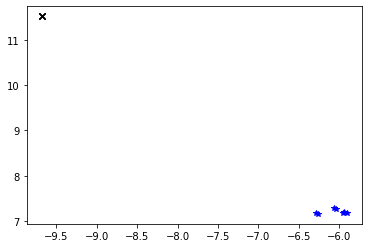

In [243]:

sub = ans[ans['hit_id']==27373.0]

plt.plot(sub.z, sub.r, "kx")
plt.plot(sub.prev_z, sub.prev_r, "b*")
#plt.

In [240]:
ans

,hit_id,x,y,z,r,layer_id,volume_id,module_id,phi,particle_id,...,prev_r,prev_pid,prev_prev_z,prev_prev_r,correct_z,correct_r,m,b,is_correct,reward
32003,27116,6.005770,-9.891340,-9.734819,11.571857,6,8,278,-1.025118,4503874505277440,...,7.184566,4.503875e+15,-3.187340,3.255892,-9.734819,11.571857,-1.270881,-0.794837,1,0.000000
33102,27156,9.782209,-6.277180,-9.763559,11.623021,6,8,282,-0.570514,108092988126658560,...,7.184566,4.503875e+15,-3.187340,3.255892,-9.734819,11.571857,-1.270881,-0.794837,0,0.058683
32830,26977,-11.148800,-3.236740,-9.750930,11.609144,6,8,263,-2.859038,247701415479214080,...,7.184566,4.503875e+15,-3.187340,3.255892,-9.734819,11.571857,-1.270881,-0.794837,0,0.040618
32689,27144,9.017350,-7.301490,-9.744240,11.602774,6,8,281,-0.680637,589975674354139136,...,7.184566,4.503875e+15,-3.187340,3.255892,-9.734819,11.571857,-1.270881,-0.794837,0,0.032320
30761,27373,-6.357740,9.604540,-9.676590,11.518162,6,8,304,2.155528,112592327146471424,...,7.184566,4.503875e+15,-3.187340,3.255892,-9.734819,11.571857,-1.270881,-0.794837,0,0.079208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91305,98324,90.159195,-0.934988,-180.550003,90.164047,8,16,49,-0.010370,644027116219793408,...,76.579079,9.007251e+17,-121.550003,64.120651,-179.449997,86.963295,-0.441788,10.421288,0,3.384498
91185,98339,88.903900,14.467199,-180.550003,90.073318,8,16,53,0.161315,193667840677511168,...,76.579079,9.007251e+17,-121.550003,64.120651,-179.449997,86.963295,-0.441788,10.421288,0,3.298827
91048,98318,89.167999,-0.961926,-179.449997,89.173187,8,16,48,-0.010787,644027116219793408,...,76.579079,9.007251e+17,-121.550003,64.120651,-179.449997,86.963295,-0.441788,10.421288,0,2.209892
90950,98334,87.824295,14.881599,-179.449997,89.076202,8,16,52,0.167853,297247471011102720,...,76.579079,9.007251e+17,-121.550003,64.120651,-179.449997,86.963295,-0.441788,10.421288,0,2.112907


In [244]:
model.predict(sub[['z', 'r', 'm', 'b', 'prev_z', 'prev_r', 'prev_prev_z', 'prev_prev_r']])

array([[1.6668391],
       [1.6668391],
       [1.6668391],
       [1.6668391],
       [1.6668391],
       [1.6668391],
       [1.6668391]], dtype=float32)

In [194]:
s = allowed_tracks[allowed_tracks['hit_id']==35065]

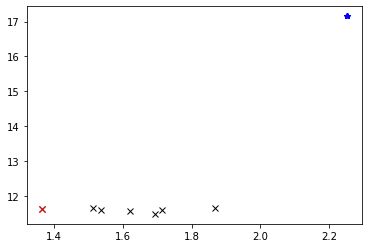

In [202]:
cor = s[s['is_correct']==1]
plt.plot(s.z, s.r, "b*")
plt.plot(s.prev_z, s.prev_r, "kx")
plt.plot(cor.prev_z, cor.prev_r, "rx")

In [200]:
s[s['is_correct']==1]

,Unnamed: 0,index,hit_id,x,y,z,r,layer_id,volume_id,module_id,...,prev_hit_id,prev_z,prev_r,prev_pid,correct_z,correct_r,m,b,is_correct,reward
183241,0,43038,35065,14.7618,8.73102,2.25045,17.150553,8,8,592,...,29958.0,1.36531,11.638652,3.738135e+17,2.25045,17.150553,6.297855,3.040127,1,2.711616e-07


In [138]:
#for a rgression, rmsprop is usually quite good 
#optimizer = keras.optimizers.rmsprop(learning_rate=0.001)

class_weight = {0: 1.,
                1: 10.}
model.compile(loss='binary_crossentropy',metrics=['accuracy'], )
#epochs is how many times is all of the data going to go through the neural net
#batch_size is how many rows of the data to consider at any one time - but all of the data 
#will be used in one epoch 

#batch_size is usually set in powers of two 
model.fit(x_train, y_train, epochs=4, batch_size=1024, class_weight=class_weight)

Epoch 1/4
2752/4958 [===============>..............] - ETA: 10:05 - loss: 1.2830 - accuracy: 0.0946

KeyboardInterrupt: 

In [150]:

preds_test = model.predict(x_test)

accuracy_test = accuracy_score(y_test, np.round(preds_test))
#accuracy_test = accuracy_score(y_test, np.where(preds > 0.4, 1, 0))
preds_train = model.predict(x_train)
accuracy_train = accuracy_score(y_train, np.round(preds_train))

print('test :', accuracy_test, 'train: ', accuracy_train)

KeyboardInterrupt: 

In [170]:
tn, fp, fn, tp = confusion_matrix(y_test, np.round(preds_test)).ravel()

print(tn, fp, fn, tp)

110268 356232 6610 42460


In [131]:
(tn+tp)/(tn+tp+fp+fn)

0.16441528367425703

In [128]:
np.round(preds[:1000])

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],

In [101]:
x_train

,z,r,m,b,prev_z,prev_r
50987,179.550003,29.872623,0.162366,0.823942,149.850006,25.154535
38875,-95.800003,15.461530,-0.157362,-0.066883,-81.800003,12.805353
60338,53.900002,49.646660,0.919437,0.204247,38.980000,36.043892
65315,179.550003,58.932789,0.298429,7.051678,150.149994,51.860859
56839,-63.340004,36.482754,-0.576674,-0.215286,-46.239998,26.450098
...,...,...,...,...,...,...
55012,-46.020000,36.041637,-0.772955,-0.263218,-33.760002,25.831736
66759,-5.405710,65.705231,-16.603107,-6.587986,-3.420000,50.194641
64113,180.149994,52.832836,0.281791,1.032673,150.149994,43.343647
35183,95.800003,11.855126,0.123651,0.008675,82.199997,10.172819


In [20]:
allowed_tracks.get_level_values()

AttributeError: 'DataFrame' object has no attribute 'get_level_values'

In [25]:
comp_hits[['prev_hit_id', 'prev_z', 'prev_r', 'prev_pid', 'correct_z','correct_r']] = row[['hit_id', 'z', 'r', 'particle_id', 'next_z', 'next_r']]

In [35]:
comp_hits['is_correct'] = list(map(int, (comp_hits['correct_z'] == comp_hits['z']) & (comp_hits['correct_r'] == comp_hits['r']).values))

In [36]:
comp_hits

,hit_id,x,y,z,r,layer_id,volume_id,module_id,phi,particle_id,...,unique_layer_id,z_2,diff_z,prev_hit_id,prev_z,prev_r,prev_pid,correct_z,correct_r,is_correct
1806,10497,-2.756000,1.551070,-70.250000,3.162492,12,7,98,2.628977,369296543833915392,...,12.0,-81.750000,-11.500000,12494.0,-60.200001,3.060462,5.314248e+17,-69.75,3.537262,0
2094,9982,0.282787,3.159080,-70.250000,3.171711,12,7,77,1.481519,544935829789736960,...,12.0,-81.800003,-11.550003,12494.0,-60.200001,3.060462,5.314248e+17,-69.75,3.537262,0
1840,9132,1.868210,-2.553090,-70.199997,3.163618,12,7,39,-0.939081,526921774877638656,...,12.0,-70.250000,-0.050003,12494.0,-60.200001,3.060462,5.314248e+17,-69.75,3.537262,0
2041,10660,-3.162860,-0.194946,-69.750000,3.168862,12,7,106,-3.080034,571986014856282112,...,12.0,-69.800003,-0.050003,12494.0,-60.200001,3.060462,5.314248e+17,-69.75,3.537262,0
2080,10111,0.280567,3.158310,-70.199997,3.170748,12,7,82,1.482194,544935829789736960,...,12.0,-70.250000,-0.050003,12494.0,-60.200001,3.060462,5.314248e+17,-69.75,3.537262,0
2082,8426,-3.165120,-0.191680,-69.800003,3.170919,12,7,4,-3.081106,571986014856282112,...,12.0,-70.250000,-0.449997,12494.0,-60.200001,3.060462,5.314248e+17,-69.75,3.537262,0
1754,10333,-2.115190,2.349540,-70.199997,3.161387,12,7,93,2.303753,756606180507254784,...,12.0,-81.750000,-11.550003,12494.0,-60.200001,3.060462,5.314248e+17,-69.75,3.537262,0
2433,10160,-0.640201,3.127120,-69.750000,3.191980,12,7,85,1.772731,4508135112835072,...,12.0,-70.199997,-0.449997,12494.0,-60.200001,3.060462,5.314248e+17,-69.75,3.537262,0
4122,10331,-2.426510,2.105840,-70.199997,3.212867,12,7,93,2.426828,806146463603097600,...,12.0,-70.250000,-0.050003,12494.0,-60.200001,3.060462,5.314248e+17,-69.75,3.537262,0
4144,10110,-0.646437,3.147420,-70.199997,3.213119,12,7,82,1.773366,4508135112835072,...,12.0,-70.250000,-0.050003,12494.0,-60.200001,3.060462,5.314248e+17,-69.75,3.537262,0


In [12]:
distances = np.array([2, 30, 1002, 1230, 124, 2, 6, 19, 384, 1, 22, 49, 28])

In [ ]:
        if num_close == 0: 
            idx = np.argmin(distances)
            one_hit = pd.DataFrame([comp_hits.iloc[idx]]) 
            final = pd.concat([one_hit, one_hit])
            #print(final)
        elif len(comp_hits) > num_close: 
            idx = np.argpartition(distances, num_close)
            final = comp_hits.iloc[idx][:num_close]


In [56]:
num_close = 10 
idx = np.argpartition(distances, num_close)


In [61]:
final = distances[idx]


In [62]:
final

array([   2,    2,    1,    6,   22,   28,   30,   19,   49,  124,  384,
       1002, 1230])

In [10]:
distances[distances.argsort()[:1]]


NameError: name 'distances' is not defined

In [151]:

ans = pd.DataFrame({})
num_close = 10
non = [] 
dl = DataLoader() 


hits, allowed_pids = dl.load_data_trackml(1)
comp = Find_Compatible_Hits_ModuleMap_Line_New(hits)

allowed_tracks = hits[hits['particle_id'].isin(allowed_pids)]

smallest_rs = allowed_tracks.groupby(['particle_id', 'unique_layer_id'])['r'].min()
allowed_tracks= allowed_tracks.merge(smallest_rs)

allowed_tracks[['prev_z', 'prev_r']] = allowed_tracks.groupby('particle_id')[['z', 'r']].shift(1)
allowed_tracks['m'] = (allowed_tracks['r'] - allowed_tracks['prev_r'])/(allowed_tracks['z'] - allowed_tracks['prev_z'])
allowed_tracks['b'] = allowed_tracks['r'] - allowed_tracks['m']*allowed_tracks['z']
allowed_tracks[['next_r', 'next_z', 'next_hit_id']] = allowed_tracks.groupby('particle_id')[['r', 'z', 'hit_id']].shift(-1)
allowed_tracks = allowed_tracks.dropna()

for pid in tqdm(np.unique(allowed_tracks.particle_id)): 
    p = allowed_tracks[allowed_tracks['particle_id']==pid]
    for i in range(len(p)): 
        row = p.iloc[i]
        comp_hits = comp.get_comp_hits_notrow(row.z, row.r, row.m, row.b, num_close)[0]
        comp_hits[['prev_hit_id', 'prev_z', 'prev_r', 'prev_pid', 'correct_z','correct_r', 'm', 'b']] = row[['hit_id', 'z', 'r', 'particle_id', 'next_z', 'next_r', 'm', 'b']]
        comp_hits['is_correct'] = list(map(int, (comp_hits['correct_z'] == comp_hits['z']) & (comp_hits['correct_r'] == comp_hits['r']).values))
        if sum(comp_hits['is_correct'])==0: 
            non.append([pid, index])
        ans = pd.concat([ans, comp_hits], axis=0)


CPU times: user 26 µs, sys: 0 ns, total: 26 µs
Wall time: 33.4 µs
CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.3 µs
CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 12.2 µs


  0%|▎                                                                                                                    | 20/6629 [00:04<27:03,  4.07it/s]


KeyboardInterrupt: 

In [152]:
p

,hit_id,x,y,z,r,layer_id,volume_id,module_id,phi,particle_id,...,unique_layer_id,z_2,diff_z,prev_z,prev_r,m,b,next_r,next_z,next_hit_id
13273,26787,5.957990,-3.876170,1.14031,7.107907,4,8,237,-0.576785,4505592492195840,...,2.0,1.16652,0.026210,0.593736,3.166369,7.211353,-1.115271,11.655694,1.770460,33141.0
25709,33141,9.708370,-6.450020,1.77046,11.655694,6,8,386,-0.586416,4505592492195840,...,3.0,2.54415,0.773690,1.140310,7.107907,7.216992,-1.121701,17.159658,2.544150,38958.0
31444,38958,14.185300,-9.655630,2.54415,17.159658,8,8,578,-0.597641,4505592492195840,...,4.0,3.78000,1.235850,1.770460,11.655694,7.113914,-0.939207,25.948465,3.780000,67811.0
36316,67811,21.186800,-14.981400,3.78000,25.948465,2,13,417,-0.615482,4505592492195840,...,5.0,5.20000,1.420000,2.544150,17.159658,7.111547,-0.933184,35.753273,5.200000,74639.0
42149,74639,28.758301,-21.242800,5.20000,35.753273,4,13,639,-0.636208,4505592492195840,...,6.0,5.22000,0.020000,3.780000,25.948465,6.904795,-0.151657,35.753273,5.200000,74639.0
49631,80481,39.311401,-30.895599,7.24000,49.999245,6,13,889,-0.666096,4505592492195840,...,7.0,9.52000,2.279999,5.200000,35.753273,6.983318,-0.559978,65.943169,9.520000,85972.0
54627,85972,50.464699,-42.447800,9.52000,65.943169,8,13,1162,-0.699327,4505592492195840,...,8.0,11.92000,2.400001,7.240000,49.999245,6.992951,-0.629723,81.565292,11.920000,100843.0
57033,100843,60.668102,-54.518597,11.92000,81.565292,2,17,1367,-0.732062,4505592492195840,...,9.0,11.92000,0.000000,9.520000,65.943169,6.509217,3.975426,101.702225,15.160001,105664.0


In [154]:
def find_module_compatible_hits(hit2, m): 


    if m > 0: 
        compy = hits[hits['z'] > hit2.z + 0.01] 
    else: 
        compy = hits[hits['z'] < hit2.z - 0.01]

    comp_hits = compy[(compy['discrete_module_id'].isin(comp_mod)) & 
                (compy['r'] > (hit2.r +0.1)) & (compy['r'] != self.prev_hit_buffer.r) & (compy['unique_layer_id']!=hit2.unique_layer_id)]# & 
                #(np.abs(hits['z']) > np.abs(hit2.z))]
    if hit2.unique_layer_id == self.prev_hit_buffer.unique_layer_id == self.prev_prev_buffer.unique_layer_id: 
    #if hit2.unique_layer_id == self.prev_hit_buffer.unique_layer_id: 
        comp_hits = comp_hits[comp_hits['unique_layer_id']!=hit2.unique_layer_id]

    if len(comp_hits) == 0: 
        #print("htats right i went here")
        if m > 0: 
            compy = hits[hits['z'] > hit2.z] 
        else: 
            compy = hits[hits['z'] < hit2.z]

        comp_hits = compy[(compy['discrete_module_id'].isin(comp_mod)) & 
                (compy['r'] > hit2.r) & (compy['r'] != self.prev_hit_buffer.r)]# & 

    if len(comp_hits) ==0 : 
        print("mwhahha I went here loliz")
    # TODO: fix this 
        #comp_hits = pd.concat([hit2_df])
        hit2_df = pd.DataFrame([hit2])

        #comp_hits = hit2_df
        comp_hits = hits[hits['discrete_module_id'].isin(comp_mod)]
        if(len(comp_hits)==0):
            print("no hits in the comp mod even though comp is", comp_mod)
    #print("usin hit 2 as comp")
        self.done = True 

    return comp_hits 
    

In [156]:
row = p.iloc[0]

In [42]:
num_close = 10


In [218]:
    
def process_to_csv(file_number):
    t0 = time.time()
    ans = pd.DataFrame({})


    hits, allowed_pids = dl.load_data_trackml(file_number)
    comp = Find_Compatible_Hits_ModuleMap_Line_New(hits)

    allowed_tracks = hits[hits['particle_id'].isin(allowed_pids)]

    smallest_rs = allowed_tracks.groupby(['particle_id', 'unique_layer_id'])['r'].min()
    allowed_tracks= allowed_tracks.merge(smallest_rs)


    allowed_tracks[['prev_z', 'prev_r']] = allowed_tracks.groupby('particle_id')[['z', 'r']].shift(1)
    allowed_tracks['m'] = (allowed_tracks['r'] - allowed_tracks['prev_r'])/(allowed_tracks['z'] - allowed_tracks['prev_z'])
    allowed_tracks['b'] = allowed_tracks['r'] - allowed_tracks['m']*allowed_tracks['z']
    allowed_tracks[['next_r', 'next_z', 'next_hit_id']] = allowed_tracks.groupby('particle_id')[['r', 'z', 'hit_id']].shift(-1)
    allowed_tracks = allowed_tracks.dropna()

    for pid in np.unique(allowed_tracks.particle_id):
        p = allowed_tracks[allowed_tracks['particle_id']==pid]

        comp_mod = [mappings[x] for x in p.discrete_module_id.astype(str).values]

        compy = [hits[hits['z']*np.sign(p['m'].iloc[0]) > (np.sign(p['m'].iloc[0])*z_val + 0.1)] for z_val in p.z]

        comp_hits = [compy[i][(compy[i]['discrete_module_id'].isin(comp_mod[i])) & (compy[i]['unique_layer_id']!=p.iloc[i].unique_layer_id)] for i in range(len(p))]

        distances = [calc_distance(p.iloc[i].m, p.iloc[i].b, comp_hits[i].z, comp_hits[i].r) for i in range(len(p))] 

        comp_hits = [comp_hits[i].iloc[distances[i].argsort()[:num_close]] for i in range(len(p))]

        comp_hits = [comp_hits[i].reset_index().join(pd.DataFrame([p.iloc[i][['hit_id', 'z', 'r', 'prev_z', 'prev_r','particle_id', 'next_z', 'next_r', 'm', 'b']]]*len(comp_hits[i])).reset_index(), rsuffix='_1') for i in range(len(p))]

        comp_hits = [comp_hits[i].rename({'hit_id_1': 'prev_hit_id', 'z_1':'prev_z', 'r_1':'prev_r', 'prev_z_1':'prev_prev_z', 'prev_r_1':'prev_prev_r', 'particle_id_1':'prev_pid', 'next_z':'correct_z', 'next_r':'correct_r'}, axis=1) for i in range(len(p))]

        comp_hits = pd.concat(comp_hits)

        comp_hits['is_correct'] = list(map(int, (comp_hits['correct_z'] == comp_hits['z']) & (comp_hits['correct_r'] == comp_hits['r']).values))

        ans = pd.concat([ans, comp_hits], axis=0)
    
    ans.to_csv('nn_control_data_second_'+str(file_number)+'.csv')
    t1 = time.time()
    print("saved file number", str(file_number), "and the time was ", t1-t0)
    


In [219]:
n_workers = 4


with mp.Pool(processes=n_workers) as pool:
    process_func = partial(process_to_csv)
    pool.map(process_func, list(range(4)))



Process ForkPoolWorker-19:
Process ForkPoolWorker-18:
Process ForkPoolWorker-20:
Process ForkPoolWorker-17:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/lhv14/anaconda3/envs/garage/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/lhv14/anaconda3/envs/garage/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/lhv14/anaconda3/envs/garage/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/lhv14/anaconda3/envs/garage/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/lhv14/anaconda3/envs/garage/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/lhv14/anaconda3/envs/garage/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  

KeyboardInterrupt: 

In [8]:
import json
f = open("/home/lhv14/mapping_noMissing_noPtcut__noDoubles_1000.json") 
# returns JSON object as 
# a dictionary*
mappings = json.load(f)


In [106]:
ans

,index,hit_id,x,y,z,r,layer_id,volume_id,module_id,phi,...,index_1,prev_hit_id,prev_z,prev_r,prev_pid,correct_z,correct_r,m,b,is_correct
0,32003,27116,6.005770,-9.891340,-9.734819,11.571857,6,8,278,-1.025118,...,12345,22100.0,-6.278640,7.184566,4.503875e+15,-9.734819,11.571857,-1.270881,-0.794837,1
1,33102,27156,9.782209,-6.277180,-9.763559,11.623021,6,8,282,-0.570514,...,12345,22100.0,-6.278640,7.184566,4.503875e+15,-9.734819,11.571857,-1.270881,-0.794837,0
2,32830,26977,-11.148800,-3.236740,-9.750930,11.609144,6,8,263,-2.859038,...,12345,22100.0,-6.278640,7.184566,4.503875e+15,-9.734819,11.571857,-1.270881,-0.794837,0
3,32689,27144,9.017350,-7.301490,-9.744240,11.602774,6,8,281,-0.680637,...,12345,22100.0,-6.278640,7.184566,4.503875e+15,-9.734819,11.571857,-1.270881,-0.794837,0
4,30761,27373,-6.357740,9.604540,-9.676590,11.518162,6,8,304,2.155528,...,12345,22100.0,-6.278640,7.184566,4.503875e+15,-9.734819,11.571857,-1.270881,-0.794837,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,69672,93740,-75.129898,8.423770,254.449997,75.600670,10,18,97,3.029936,...,43274,78649.0,214.550003,63.619129,4.506623e+15,294.450012,85.282974,0.273960,4.841064,0
6,73266,94121,-85.770500,14.242101,295.549988,86.944901,12,18,96,2.977045,...,43274,78649.0,214.550003,63.619129,4.506623e+15,294.450012,85.282974,0.273960,4.841064,0
7,73338,94118,-85.841599,14.187500,294.750000,87.006119,12,18,95,2.977798,...,43274,78649.0,214.550003,63.619129,4.506623e+15,294.450012,85.282974,0.273960,4.841064,0
8,73277,94090,-72.437904,48.112801,294.450012,86.960281,12,18,89,2.555304,...,43274,78649.0,214.550003,63.619129,4.506623e+15,294.450012,85.282974,0.273960,4.841064,0


In [171]:
np.sign(-1)*x

-1

In [187]:
hits['z']*np.sign(p['m'].iloc[0]) > (np.sign(p['m'].iloc[0])*p.z + 0.1)

ValueError: Can only compare identically-labeled Series objects

In [184]:
np.sign(p['m'].iloc[0])

1.0

In [191]:
comp_hits = compy[(compy['discrete_module_id'].isin(comp_mod)) & 
                    (compy['r'] > (hit2.r +0.1)) & (compy['r'] != self.prev_hit_buffer.r) & (compy['unique_layer_id']!=hit2.unique_layer_id)]# & 

[       hit_id          x           y          z           r  layer_id  \
 1       44720  -2.130470   -2.144160  69.800003    3.022635         4   
 3       42640   2.514080   -1.680030  59.750000    3.023756         2   
 6       47776   0.140738   -3.023170  81.800003    3.026444         6   
 7       49257  -0.433786    2.995560  81.750000    3.026805         6   
 9       41702  -2.638280   -1.484800  59.750000    3.027400         2   
 ...       ...        ...         ...        ...         ...       ...   
 93002  107390  66.423996  -78.102005  78.620003  102.528381         4   
 93003  106994 -12.890200  101.715004  56.940002  102.528526         4   
 93004  105864 -52.297802  -88.188599  15.740000  102.529457         4   
 93006  106913  90.278198  -48.604000  59.099998  102.530495         4   
 93007  106491  12.456500  101.771996  39.579998  102.531479         4   
 
        volume_id  module_id       phi         particle_id        pt  nhits  q  \
 1              9         14

In [23]:
[compy[i][(compy[i]['discrete_module_id'].isin(comp_mod[i])) & (compy[i]['unique_layer_id']!=p.iloc[i].unique_layer_id)] for i in range(len(p))]

IndexError: list index out of range

In [25]:
len(compy)

7

In [27]:
len(p)

9

In [29]:
len(p.z)

9

In [30]:
len(comp_mod)

9

In [33]:
[len(x) for x in comp_hits]

[245, 146]

In [34]:
calc_distance(1, 2, 3, 5)

NameError: name 'calc_distance' is not defined

In [51]:
[comp_hits[i]['test'] = p.iloc[i]['z'] for i in range(len(p))]

SyntaxError: invalid syntax (1309212822.py, line 1)

In [60]:
tmp = comp_hits

In [61]:
tmp

,hit_id,x,y,z,r,layer_id,volume_id,module_id,phi,particle_id,pt,nhits,q,discrete_module_id,Unnamed: 0,unique_layer_id,z_2,diff_z
32003,27116,6.005770,-9.891340,-9.734819,11.571857,6,8,278,-1.025118,4503874505277440,2.227651,11,-1,1705,2,3.0,-14.219501,-4.484681
33102,27156,9.782209,-6.277180,-9.763559,11.623021,6,8,282,-0.570514,108092988126658560,0.638206,13,-1,1709,2,3.0,-14.370600,-4.607040
32830,26977,-11.148800,-3.236740,-9.750930,11.609144,6,8,263,-2.859038,247701415479214080,0.424455,13,-1,1690,2,3.0,-14.498500,-4.747570
32689,27144,9.017350,-7.301490,-9.744240,11.602774,6,8,281,-0.680637,589975674354139136,0.501571,10,1,1708,2,3.0,-14.902699,-5.158460
30761,27373,-6.357740,9.604540,-9.676590,11.518162,6,8,304,2.155528,112592327146471424,0.456074,10,-1,1731,2,3.0,-14.662000,-4.985410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75520,87674,29.325201,-97.576897,-84.020004,101.888268,4,17,350,-1.278849,4506898162253824,2.127515,15,1,15297,15,10.0,-84.020004,0.000000
75629,87687,78.181297,-65.410400,-77.540001,101.935448,4,17,364,-0.696693,292754660341579776,0.873766,13,1,15311,15,10.0,NaN,NaN
76114,87673,27.233898,-98.471001,-77.540001,102.167618,4,17,349,-1.300973,648524118777397248,0.360263,14,1,15296,15,10.0,NaN,NaN
75171,87912,78.032700,-65.144501,-76.959999,101.650917,4,17,516,-0.695624,292754660341579776,0.873766,13,1,15463,15,10.0,-77.540001,-0.580002


In [64]:
row = p.iloc[0]

In [100]:
tmp1 = tmp.reset_index().join(pd.DataFrame([row[['hit_id', 'z', 'r', 'particle_id', 'next_z', 'next_r', 'm', 'b']]]*len(tmp)).reset_index(), rsuffix='_1')
tmp1.rename({'hit_id_1': 'prev_hit_id', 'z_1':'prev_z', 'r_1':'prev_r', 'particle_id_1':'prev_pid', 'next_z':'correct_z', 'next_r':'correct_r'}, axis=1)

,index,hit_id,x,y,z,r,layer_id,volume_id,module_id,phi,...,diff_z,index_1,prev_hit_id,prev_z,prev_r,prev_pid,correct_z,correct_r,m,b
0,32003,27116,6.005770,-9.891340,-9.734819,11.571857,6,8,278,-1.025118,...,-4.484681,12345,22100.0,-6.27864,7.184566,4.503875e+15,-9.734819,11.571857,-1.270881,-0.794837
1,33102,27156,9.782209,-6.277180,-9.763559,11.623021,6,8,282,-0.570514,...,-4.607040,12345,22100.0,-6.27864,7.184566,4.503875e+15,-9.734819,11.571857,-1.270881,-0.794837
2,32830,26977,-11.148800,-3.236740,-9.750930,11.609144,6,8,263,-2.859038,...,-4.747570,12345,22100.0,-6.27864,7.184566,4.503875e+15,-9.734819,11.571857,-1.270881,-0.794837
3,32689,27144,9.017350,-7.301490,-9.744240,11.602774,6,8,281,-0.680637,...,-5.158460,12345,22100.0,-6.27864,7.184566,4.503875e+15,-9.734819,11.571857,-1.270881,-0.794837
4,30761,27373,-6.357740,9.604540,-9.676590,11.518162,6,8,304,2.155528,...,-4.985410,12345,22100.0,-6.27864,7.184566,4.503875e+15,-9.734819,11.571857,-1.270881,-0.794837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,75520,87674,29.325201,-97.576897,-84.020004,101.888268,4,17,350,-1.278849,...,0.000000,12345,22100.0,-6.27864,7.184566,4.503875e+15,-9.734819,11.571857,-1.270881,-0.794837
76,75629,87687,78.181297,-65.410400,-77.540001,101.935448,4,17,364,-0.696693,...,NaN,12345,22100.0,-6.27864,7.184566,4.503875e+15,-9.734819,11.571857,-1.270881,-0.794837
77,76114,87673,27.233898,-98.471001,-77.540001,102.167618,4,17,349,-1.300973,...,NaN,12345,22100.0,-6.27864,7.184566,4.503875e+15,-9.734819,11.571857,-1.270881,-0.794837
78,75171,87912,78.032700,-65.144501,-76.959999,101.650917,4,17,516,-0.695624,...,-0.580002,12345,22100.0,-6.27864,7.184566,4.503875e+15,-9.734819,11.571857,-1.270881,-0.794837


In [98]:
hiit = pd.DataFrame([row[['hit_id', 'z', 'r', 'particle_id', 'next_z', 'next_r', 'm', 'b']]]*len(tmp)).reset_index()

In [99]:
tmp.reset_index().join(hiit, rsuffix='_1')

,index,hit_id,x,y,z,r,layer_id,volume_id,module_id,phi,...,diff_z,index_1,hit_id_1,z_1,r_1,particle_id_1,next_z,next_r,m,b
0,32003,27116,6.005770,-9.891340,-9.734819,11.571857,6,8,278,-1.025118,...,-4.484681,12345,22100.0,-6.27864,7.184566,4.503875e+15,-9.734819,11.571857,-1.270881,-0.794837
1,33102,27156,9.782209,-6.277180,-9.763559,11.623021,6,8,282,-0.570514,...,-4.607040,12345,22100.0,-6.27864,7.184566,4.503875e+15,-9.734819,11.571857,-1.270881,-0.794837
2,32830,26977,-11.148800,-3.236740,-9.750930,11.609144,6,8,263,-2.859038,...,-4.747570,12345,22100.0,-6.27864,7.184566,4.503875e+15,-9.734819,11.571857,-1.270881,-0.794837
3,32689,27144,9.017350,-7.301490,-9.744240,11.602774,6,8,281,-0.680637,...,-5.158460,12345,22100.0,-6.27864,7.184566,4.503875e+15,-9.734819,11.571857,-1.270881,-0.794837
4,30761,27373,-6.357740,9.604540,-9.676590,11.518162,6,8,304,2.155528,...,-4.985410,12345,22100.0,-6.27864,7.184566,4.503875e+15,-9.734819,11.571857,-1.270881,-0.794837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,75520,87674,29.325201,-97.576897,-84.020004,101.888268,4,17,350,-1.278849,...,0.000000,12345,22100.0,-6.27864,7.184566,4.503875e+15,-9.734819,11.571857,-1.270881,-0.794837
76,75629,87687,78.181297,-65.410400,-77.540001,101.935448,4,17,364,-0.696693,...,NaN,12345,22100.0,-6.27864,7.184566,4.503875e+15,-9.734819,11.571857,-1.270881,-0.794837
77,76114,87673,27.233898,-98.471001,-77.540001,102.167618,4,17,349,-1.300973,...,NaN,12345,22100.0,-6.27864,7.184566,4.503875e+15,-9.734819,11.571857,-1.270881,-0.794837
78,75171,87912,78.032700,-65.144501,-76.959999,101.650917,4,17,516,-0.695624,...,-0.580002,12345,22100.0,-6.27864,7.184566,4.503875e+15,-9.734819,11.571857,-1.270881,-0.794837


In [ ]:
    comp_hits[['prev_hit_id', 'prev_z', 'prev_r', 'prev_pid', 'correct_z','correct_r', 'm', 'b']] = row[['hit_id', 'z', 'r', 'particle_id', 'next_z', 'next_r', 'm', 'b']]
